In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import sklearn.decomposition
import umap
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import scipy
import os
import numpy as np
import time
import seaborn as sns
import episcanpy as epi
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import kneighbors_graph

In [2]:
data_origin = pd.read_csv('./bu_data/sc_mat.txt', sep='\t', index_col=None)
data_imputed_IMATAC = pd.read_csv('./bu_data/imputed_IMATAC_Buenrostro.txt', sep='\t', index_col=None)
data_imputed_scale = pd.read_csv('./bu_data/bu_imputed_scale.txt', sep='\t', index_col=None)
data_imputed_scopen = pd.read_csv('./bu_data/imputed_scOpen_mat.txt', sep='\t', index_col=None)
data_imputed_sccase = pd.read_csv('./bu_data/scCASE_imputed.txt', sep='\t', header=None, index_col=None)

In [3]:
data_imputed_sccase.columns = [f'cell_{i}' for i in range(2034)]

In [4]:
data_origin = data_origin[:89600]
data_imputed_scale = data_imputed_scale[:89600]
data_imputed_sccase=data_imputed_sccase[:89600]
data_imputed_scopen=data_imputed_scopen[:89600]

In [5]:
data_origin = data_origin.drop('index', axis=1)
data_imputed_scale = data_imputed_scale.drop('index', axis=1)
data_imputed_scopen = data_imputed_scopen.drop('Unnamed: 0', axis=1)

In [ ]:
data_imputed_IMATAC[data_imputed_IMATAC < 0] = 0
data_imputed_IMATAC[data_imputed_IMATAC > 1] = 1
order = pd.DataFrame(pd.DataFrame(data_imputed_IMATAC.columns).apply(lambda i : int(i.values[0].split('_')[1]), axis=1), columns=['order'])
order = order.T
order.columns = data_imputed_IMATAC.columns
data_imputed_IMATAC = pd.concat([data_imputed_IMATAC, order], ignore_index=False, axis=0)
data_imputed_IMATAC = data_imputed_IMATAC.sort_values(by=['order'], axis=1)
data_imputed_IMATAC = data_imputed_IMATAC.drop('order', axis=0)

In [ ]:
reads_methods = [data_origin, data_imputed_IMATAC, data_imputed_scale, data_imputed_scopen, data_imputed_sccase]
methods = ['Raw', 'IMATAC', 'SCALE', 'scOpen', 'scCASE']
imputed_mat_method = {}
for i in range(len(reads_methods)):
    imputed_mat_method[methods[i]] = reads_methods[i]

##### cluster analysis

In [8]:
def umap_kmeans(reads, cells, n_components):
    data = reads
    umap_reducer = umap.UMAP(n_components=n_components)
    umap_result = umap_reducer.fit_transform(data)

    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(umap_result)
    labels = kmeans.labels_
    kmeans_result = pd.DataFrame(labels, index=cells.index, columns=['cluster'])
    # kmeans_result.to_csv(project+'/cluster_by_kmeans.csv',sep='\t')
    visual_reducer = umap.UMAP(n_components=2)
    visual_result = visual_reducer.fit_transform(umap_result)
    visual_result = pd.DataFrame(visual_result, index=cells.index, columns = [i for i in range(visual_result.shape[1])])
    return umap_result, visual_result, kmeans_result

In [9]:
# PCA
PCA_reads_methods = {}
for method in methods:
    pca = PCA(n_components=1000, svd_solver='full').fit_transform(imputed_mat_method[method].values.T)
    pca = pca[:, 1:]
    PCA_reads_methods[method] = pca

In [10]:
# umap + kmeans
umap_reads_methods = {}
kmeans_methods = {}
visiual_reads_methods = {}
cells = pd.read_csv('/media/biology/datadisk/ly/scopen/project_IMATAC_Buenrostro/matrix/filtered_cells.csv', sep='\t', index_col=0,engine='c', na_filter=False, low_memory=False)
cells.index = [f'cell_{i}' for i in range(cells.shape[0])]
for method in methods:
    umap_res, visiual_res, kmeans_res = umap_kmeans(PCA_reads_methods[method], cells, 500)
    umap_reads_methods[method] = umap_res
    kmeans_methods[method] = kmeans_res
    visiual_reads_methods[method] = visiual_res

In [32]:
umap_origin = pd.DataFrame(visiual_reads_methods['Raw'])
umap_IMATAC = pd.DataFrame(visiual_reads_methods['IMATAC'])
umap_scale = pd.DataFrame(visiual_reads_methods['SCALE'])
umap_scopen = pd.DataFrame(visiual_reads_methods['scOpen'])
umap_sccase = pd.DataFrame(visiual_reads_methods['scCASE'])

In [ ]:
label = pd.read_csv('/filtered_cells.csv', sep='\t', index_col=0)
label.index = [f'cell_{i}' for i in range(umap_origin.shape[0])]

In [34]:
umap_origin['label'] = label['notes']
umap_IMATAC['label'] = label['notes']
umap_scale['label'] = label['notes']
umap_scopen['label'] = label['notes']
umap_sccase['label'] = label['notes']

In [35]:
umap_origin['Cluster'] = kmeans_methods['Raw']
umap_IMATAC['Cluster'] = kmeans_methods['IMATAC']
umap_scale['Cluster'] = kmeans_methods['SCALE']
umap_scopen['Cluster'] = kmeans_methods['scOpen']
umap_sccase['Cluster'] = kmeans_methods['scCASE']

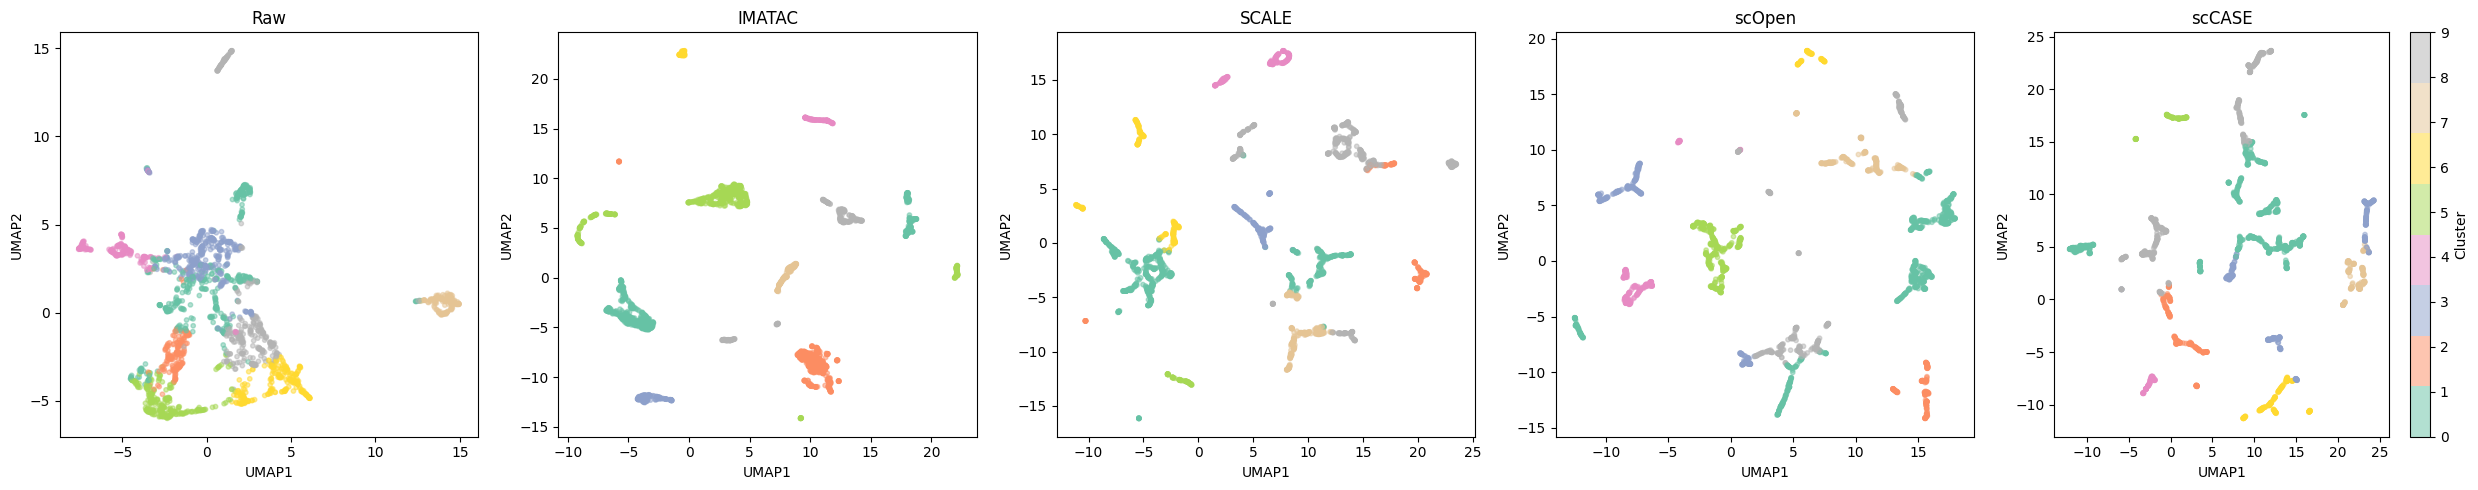

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(1, 5, figsize=(25, 5)) 
palette = sns.color_palette("Set2", n_colors=len(umap_origin['Cluster'].unique()))
for i, (umap_df, title) in enumerate(zip(
    [umap_origin, umap_IMATAC, umap_scale, umap_scopen, umap_sccase],
    ['Raw', 'IMATAC', 'SCALE', 'scOpen', 'scCASE']
)):
    scatter = axs[i].scatter(
        umap_df[0], umap_df[1], 
        c=umap_df['Cluster'],
        cmap='Set2',  
        alpha=0.5, 
        s=10
    )
    axs[i].set_title(title)
    axs[i].set_xlabel('UMAP1')
    axs[i].set_ylabel('UMAP2')
    if i == 4:  
        plt.colorbar(scatter, ax=axs[i], label='Cluster')
plt.tight_layout()
plt.show()


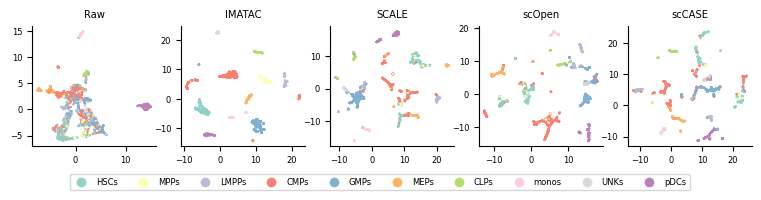

In [ ]:
plt.rcParams['font.size'] = 6
plt.rcParams['font.family'] = ['sans-serif']
fig, axs = plt.subplots(1, 5, figsize=(8, 2))  
for i, (umap_df, title) in enumerate(zip(
    [umap_origin, umap_IMATAC, umap_scale, umap_scopen, umap_sccase],
    ['Raw', 'IMATAC', 'SCALE', 'scOpen', 'scCASE']
)):
    unique_labels = umap_df['label'].unique()
    unique_labels=['HSCs','MPPs', 'LMPPs','CMPs','GMPs','MEPs','CLPs','monos','UNKs','pDCs']
    palette = sns.color_palette("Set3", n_colors=10)

    label_color_map = dict(zip(unique_labels, palette))

    scatter = axs[i].scatter(
        umap_df[0], umap_df[1], 
        c=(umap_df['label']+'s').map(label_color_map),  
        alpha=1, 
        s=0.5
    )
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(title)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_map[label], markersize=8) 
               for label in unique_labels]
    
axs[2].legend(handles, unique_labels, loc='upper center', bbox_to_anchor=(0.4, -0.2), ncol=len(unique_labels))
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.25) 

plt.savefig('./combined_embedding.png', dpi=500)
plt.show()

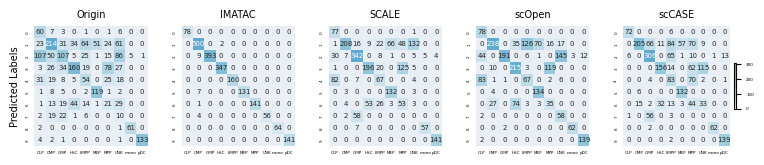

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['font.size'] = 3
plt.rcParams['font.family'] = ['sans-serif']
fig, axs = plt.subplots(1, 5, figsize=(7.8, 2))  
colors = ['#EAEFF6', '#98CADD', '#61AACF'] 
cmap = LinearSegmentedColormap.from_list('custom', colors)
heatmap = None
for i, (umap_df, title) in enumerate(zip(
    [umap_origin, umap_IMATAC, umap_scale, umap_scopen, umap_sccase],
    ['Origin', 'IMATAC', 'SCALE', 'scOpen', 'scCASE']
)):
    label_encoder = LabelEncoder()
    true_labels_encoded = label_encoder.fit_transform(umap_df['label'])
    predicted_labels = umap_df['Cluster']

    conf_matrix = confusion_matrix(true_labels_encoded, predicted_labels)

    row_ind, col_ind = linear_sum_assignment(-conf_matrix) 
    sorted_conf_matrix = conf_matrix[row_ind, :][:, col_ind]

    true_labels_names = label_encoder.inverse_transform(np.unique(true_labels_encoded))


    ax = plt.subplot(1, 5, i + 1)
    heatmap = sns.heatmap(sorted_conf_matrix, annot=True, fmt='d', cmap=cmap, 
                annot_kws={'size' : 5},
                xticklabels=true_labels_names, 
                yticklabels=np.unique(umap_df['Cluster']),
                cbar=0)
    plt.tick_params(axis='both', which='both', length=0) 
    if i==0:
        plt.ylabel('Predicted Labels', fontsize=7)
         
    plt.title(f'{title}', fontsize=7)
cbar = plt.colorbar(heatmap.collections[0], ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label('Color Scale', fontsize=5)
plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.2) 
plt.subplots_adjust(wspace=0.3)  # Set spacing between subplots
plt.savefig('./combined_confusion_mat.png', dpi=500)
# plt.tight_layout()
plt.show()

In [ ]:
# 计算ARI NMI和AMI指标
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score

results_df = pd.DataFrame(columns=['Method', 'ARI', 'NMI', 'AMI'])

def calculate_clustering_metrics(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    return ari, nmi, ami

methods = {
    'Origin': umap_origin,
    'IMATAC': umap_IMATAC,
    'SCALE': umap_scale,
    'scOpen': umap_scopen,
    'scCASE': umap_sccase
}
results_list = []

for method_name, umap_data in methods.items():
    true_labels = umap_data['label']
    predicted_labels = umap_data['Cluster']
    
    ari, nmi, ami = calculate_clustering_metrics(true_labels, predicted_labels)

    results_list.append({
        'Method': method_name,
        'ARI': ari,
        'NMI': nmi,
        'AMI': ami
    })

results_df = pd.DataFrame(results_list)
print(results_df)

   Method       ARI       NMI       AMI
0  Origin  0.217925  0.371518  0.365482
1  IMATAC  0.968114  0.972493  0.972213
2   SCALE  0.472372  0.628820  0.625228
3  scOpen  0.416577  0.628583  0.625029
4  scCASE  0.377868  0.568177  0.563964
